In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
import PIL
from IPython import display
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")

In [2]:
#dataset function to prepare dataset and images
@tf.function
def prepare_image (item):
    image = item['image']
    image = tf.cast(image, 'float32')
    image = tf.image.random_flip_left_right(image)
    image =  (image - 127.5) / 127.5 # normalize images to -1,1
    return image


In [3]:
#load the dataset
image_net = tfds.load('downsampled_imagenet')

In [4]:
image_net_train = image_net['train']
image_net_test = image_net['validation']
imagenet = image_net_train.concatenate(image_net_test)

In [5]:
from train_DCGAN import *

In [6]:
#set distribution strategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [7]:
#prepare the dataset, cache and buffer - setup prefetch for faster training
BUFFER_SIZE = 10000
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
imagenet = imagenet.map(prepare_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
imagenet = imagenet.shuffle(BUFFER_SIZE)
imagenet = imagenet.batch(BATCH_SIZE)
imagenet = imagenet.prefetch(tf.data.experimental.AUTOTUNE)

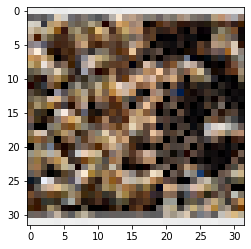

In [8]:
img = imagenet.take(1)
for each in img:
    each = each.numpy()
    plt.imshow((each[1, :, :, :] * 127.5 + 127.5).astype(np.uint8))
plt.show()

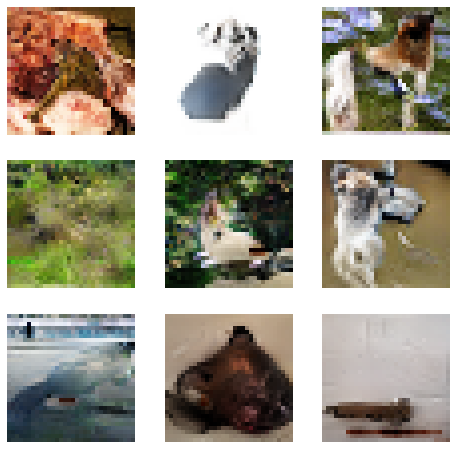

5200/5200 [==============================] - 992s 191ms/step - Discriminator_Generator_Loss: 0.2193 - Average_Discriminator_Loss: 0.2301 - Generator_Loss: 0.9226 - Discriminator_Real_Loss: 0.2409


In [11]:
with strategy.scope():
    #define optimizers
    generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5) #learning rate by x10
    discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5)
    
    #define generator architecture
    gen_dict = {'num_latent':128,
             "filter_num":[512,256,128],
             "filter_size":[8,5,5], 
             "strides":[2,2,2,2],
             'dense':(4,4,1024), 
             'activation':'relu', 
             'out_channels':3,
             'latent_distribution':'normal'}
    
    #define discriminator architecture
    disc_dict = {"filter_num": [128, 256, 512],
             "filter_size": [5, 5, 5],
             'activation': 'leakyrelu',
             'out_channels': 3,
             'dropout':0,
             'noise':False}

    #create model and compile
    model = DCGAN(gen_dict=gen_dict, disc_dict=disc_dict, batch_size=128, model_name='ImageNetFinal', distribute=True)
    model.compile(generator_optimizer, discriminator_optimizer, 
                  tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     #label_smoothing=0.1,
                                                     reduction =tf.keras.losses.Reduction.NONE))
    #Set up call backs
    save_callback = SaveModelAndCreateImages()
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model.log_path,write_graph=True,
    histogram_freq=1)
    
    #Train the model
    model.fit(x=imagenet, epochs=45, callbacks=[save_callback,tensorboard_callback],shuffle=True)
        

In [12]:
%load_ext tensorboard

In [13]:
%tensorboard --logdir=ImageNetFinal/logs/

In [14]:
#Get feature extractor from the model
FeatureExtractor = model.create_feature_extractor()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 128)  9600        input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 16, 16, 128)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 8, 8, 256)    819200      leaky_re_lu_6[0][0]              
____________________________________________________________________________________________

In [ ]:
FeatureExtractor.summary()

In [15]:
#Prep CIFAR data for training and testing
@tf.function
def prepare_image_cifar_labeled (item):
    image = item['image']
    label = item['label']
    image = tf.cast(image, 'float32')
    image =  (image - 127.5) / 127.5 # normalize images to -1,1
    return image, label


In [16]:
cifar_10 = tfds.load('cifar10')
cifar_10_train = cifar_10['train']
cifar_10_test = cifar_10['test']

In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 512
cifar_10_train = cifar_10_train.map(prepare_image_cifar_labeled, num_parallel_calls=tf.data.experimental.AUTOTUNE)
cifar_10_train = cifar_10_train.batch(BATCH_SIZE)
cifar_10_train = cifar_10_train.prefetch(tf.data.experimental.AUTOTUNE)
cifar_10_test = cifar_10_test.map(prepare_image_cifar_labeled, num_parallel_calls=tf.data.experimental.AUTOTUNE)
cifar_10_test = cifar_10_test.batch(BATCH_SIZE)
cifar_10_test = cifar_10_test.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
#function uses feature extractor to extract features for both test and train datapoints
def extract_features(model, dataset):
    img_features = []
    labels = []
    for img, label in dataset:
        img_features.append(model.predict(img))
        labels.append(label)
    
    allfeatures=img_features[0]
    for i in range(len(img_features)):
        if i == 0:
            continue
        allfeatures= np.vstack((allfeatures, img_features[i]))
        
    labels = [x.numpy() for x in labels]
    labels = np.hstack(labels)
    
    return allfeatures, labels

In [19]:
#extract train and test features
train_features, train_labels = extract_features(FeatureExtractor, cifar_10_train)
test_features, test_labels = extract_features(FeatureExtractor, cifar_10_test)

In [20]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

In [21]:
#train L2-SVM on extracted features
%%time
svm_mod = OneVsRestClassifier(LinearSVC(random_state=0, tol=1e-5,verbose=1, max_iter=1000), n_jobs=5)
svm_mod.fit(train_features,train_labels)

CPU times: user 407 ms, sys: 1.51 s, total: 1.92 s
Wall time: 8min 49s


OneVsRestClassifier(estimator=LinearSVC(random_state=0, tol=1e-05, verbose=1),
                    n_jobs=5)

In [22]:
#Evaluate performance against test set
svm_mod.score(test_features, test_labels)

0.7076